This notebook has the function to check raw counts for: 

For a specific violation type:

total number of stops, # citation, number of people not getting citation, for the rare group (99% citation rate violation type: look at 1% not getting citation): check demographics (raw counts of people of each race). Do this by year. 

Have a parameter in the function to choose county. Create visualization if possible.
(visualization might be lines for yearly counts of a specific race for cited and stopped)

Run Logistic Regression for those extremely low/extremely high citation rate categories combined!

Currently, only violation types that appear in top 30 in all 12 years and <0.05 or > 0.9 **in all years**

Check: Some violation types do not appear in all 12 years

Remove restriction 1: Include all violations (not only top 30?) -> should be easy, remove vio_cutoff

Remove restriction 2: What if citation rate fluctuates? ->?

Modification 3: should remove violation with citation rate = 1 or citation rate = 0

Problem:

1. We are filtering based on violation types (could have violations > 1) and only keep those having very high/low citation rates.

2. We are running yearly analysis

But:

1. Citation rates for a specific violation type can fluctuate throughout years

2. A violation type may not be present in all years from 2006-2017.

These lead to:...
violation A (let's say stop sign) have citation rate > 90% in 2006-2010, but < 90% in 2011-2017 -> 

If filter based on yearly citation rate: violation A will be included as samples for LR from 2006-2010, but not 2011-2017!

If filter based on overall citation rate across all years: violation A will be included as samples for all years, but for 2011-2017, it is not really a extremely high citation rate type.

So currently I am only including violations have citation rate > 0.9 for all years, or < 0.05 for all years. -> filter out some violation types, need justification.

1. Look at the raw count csv files: 'unknown'?

2. If we end up with one citation for a asian for violation type A in one year, it seems like a special case, but may be hard to generalize to systematic bias.

### Raw Counts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [ ]:
# raw counts do not remove unknown/empty values as in logistic regression
def inspect_violation(year, county=None, vio_cutoff = 30):
  print('Processing: ',year)
  df = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')
  if county:
    df = df.loc[df['county_name']==county,:]
    vio_cutoff = np.minimum(df['violation'].nunique(),vio_cutoff)

  # store demographic counts in stops
  stop_race_df = pd.DataFrame()
  # store demographic counts in citations/no-citations
  cite_race_df = pd.DataFrame()
  # select top 30 violations each
  top_vios = list(df['violation'].value_counts(dropna=False)[:vio_cutoff].index)
  total_stops = []
  violations = []
  citation_rates = []
  citations = []

  for vio in top_vios:
    temp_df = df.loc[df['violation']==vio,:]

    citation_rate = round(temp_df['citation_issued'].value_counts(dropna=False, normalize = True)[True],4)
    # only want violation categories with citation rates extremely low or extremely high
    if (citation_rate > 0.05) and (citation_rate < 0.9):
      continue

    violations.append(vio)
    total_stops.append(len(temp_df))
    citation_rates.append(citation_rate)
    citations.append(round(temp_df['citation_issued'].value_counts(dropna=False, normalize = False)[True],4))

    temp_stop_race_df = pd.DataFrame(temp_df['subject_race'].value_counts(dropna=True, normalize = False)).transpose()
    temp_stop_race_df['violation'] = vio
    temp_stop_race_df.rename(columns = {'white':'stop_white','hispanic':'stop_hispanic','black':'stop_black','unknown':'stop_unknwon','asian/pacific islander':'stop_asian/pacific islander','other':'stop_other'},inplace = True)
    stop_race_df = pd.concat([stop_race_df,temp_stop_race_df],ignore_index = True)
    

    # filter: only keep violations with citation_rate > 0.9 or < 0.05
    if citation_rate > 0.9:
      cite_df = temp_df.loc[temp_df['citation_issued']==False,:]
    elif citation_rate < 0.05:
      cite_df = temp_df.loc[temp_df['citation_issued']==True,:]

    # if race is NAN we drop it
    vio_race_df = pd.DataFrame(cite_df['subject_race'].value_counts(dropna=True, normalize = False)).transpose()
    vio_race_df['violation'] = vio
    cite_race_df = pd.concat([cite_race_df,vio_race_df],ignore_index = True)

  output_df = pd.DataFrame({'violation':violations,'total_stops':total_stops,'citations':citations,'citation_rate':citation_rates})
  output_df = output_df.merge(cite_race_df, how='inner', on='violation')
  output_df = output_df.merge(stop_race_df, how='inner', on='violation')
  output_df['year'] = [year]*len(output_df)
  #return output_df.sort_values(by = 'citation_rate', ascending = False)
  return output_df

In [ ]:
def filter_violations(res_df, method = 'all_years'):
  if method == 'all_years':
    s = res_df.groupby('violation').size()
    # print(s)
    # violation type must be present in top 30 in all 12 years and have citation rate<0.05 or >0.9 in all years in the tx data
    vios = list(s.loc[s==12].index)
    filtered_res_df = res_df.loc[res_df['violation'].isin(vios),:]
  return (vios,filtered_res_df)

In [ ]:
def cnt_csv_visualization(output_path, visual = True, county=None):
  """
  This function outputs a csv file to output_path, and create visualizations.
  county: if a county name, only consider stops in that county. If None, all counties
  """
  years = list(range(2006,2018))
  res_df = pd.DataFrame()
  for year in years:
    # get each year's top 30
    cite_rate_df = inspect_violation(year=year, county=None)
    res_df = pd.concat([res_df,cite_rate_df],ignore_index = True)
  
  # keep only violations that appear in top30 in all 12 years
  vios, filtered_res_df = filter_violations(res_df)

  filtered_res_df.to_csv(output_path, index=False)

  for vio in vios:
    vis_df = filtered_res_df.loc[filtered_res_df['violation'] == vio,:]
    print(vis_df['citation_rate'].iloc[0])
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

    x= vis_df['year']
    y1=vis_df['white']
    y2=vis_df['black']
    y3=vis_df['asian/pacific islander']
    y4=vis_df['hispanic']

    ax1.bar(x, y1, color='r',label='white')
    ax1.bar(x, y2, bottom=y1, color='b',label='black')
    ax1.bar(x, y3, bottom=y1+y2, color='y',label='asian/pacific islander')
    ax1.bar(x, y4, bottom=y1+y2+y3, color='g',label='hispanic')

    plt.suptitle(vio)
    
    if vis_df['citation_rate'].iloc[0] < 0.05:
      ax1.set_title('Raw Counts: Citation Demographic')
    else:
      ax1.set_title('Raw Counts: No Citation Demographic')

    y1=vis_df['stop_white']
    y2=vis_df['stop_black']
    y3=vis_df['stop_asian/pacific islander']
    y4=vis_df['stop_hispanic']

    ax2.bar(x, y1, color='r',label='white')
    ax2.bar(x, y2, bottom=y1, color='b',label='black')
    ax2.bar(x, y3, bottom=y1+y2, color='y',label='asian/pacific islander')
    ax2.bar(x, y4, bottom=y1+y2+y3, color='g',label='hispanic')

    ax2.set_title('Raw Counts: Stops Demographic')
    plt.legend()
    plt.show()

Processing:  2006
Processing:  2007
Processing:  2008
Processing:  2009
Processing:  2010
Processing:  2011
Processing:  2012
Processing:  2013
Processing:  2014
Processing:  2015
Processing:  2016
Processing:  2017
0.0331


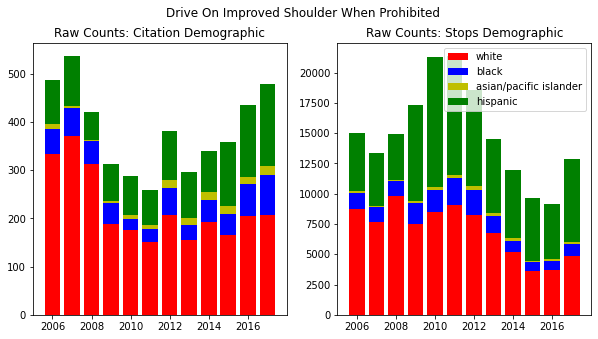

0.0028


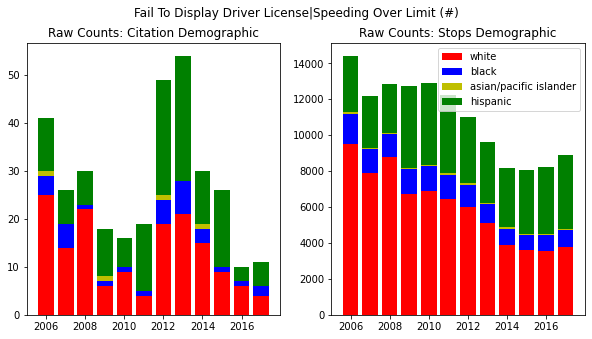

0.0033


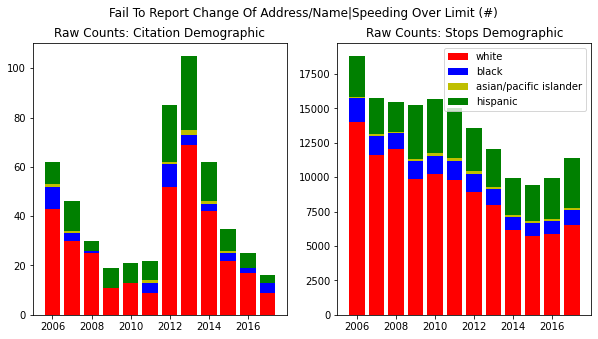

0.0235


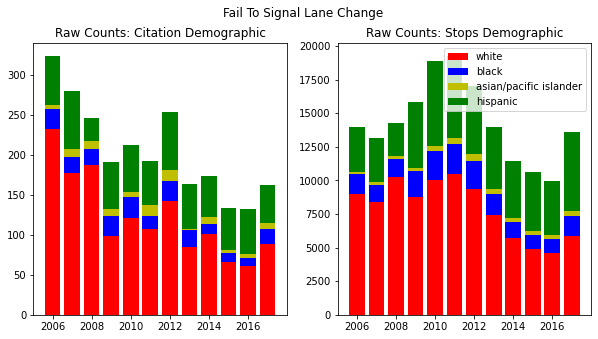

0.0094


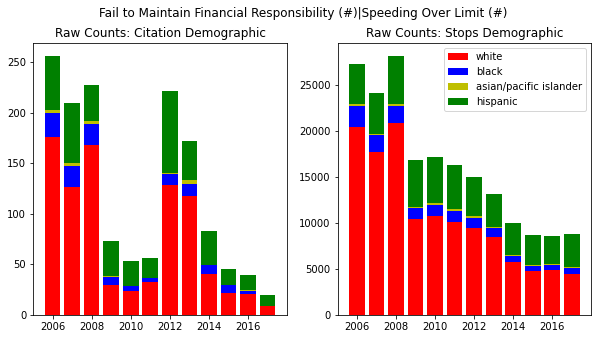

0.9985


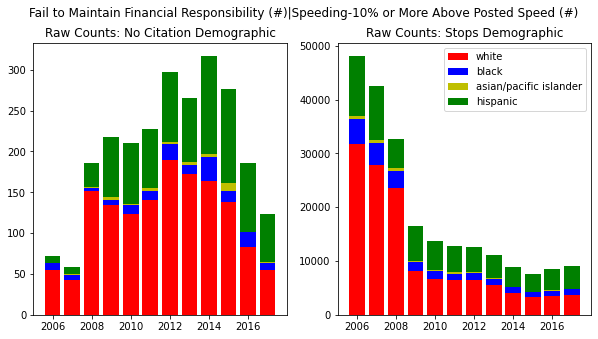

0.0021


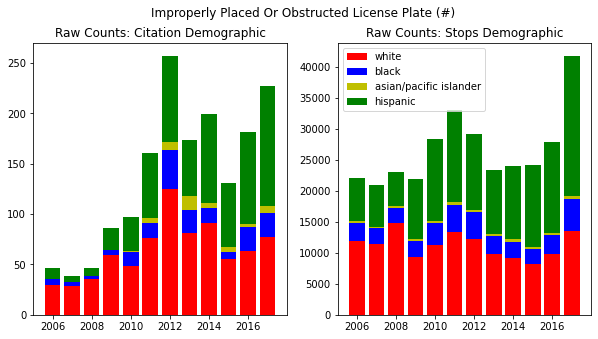

0.0075


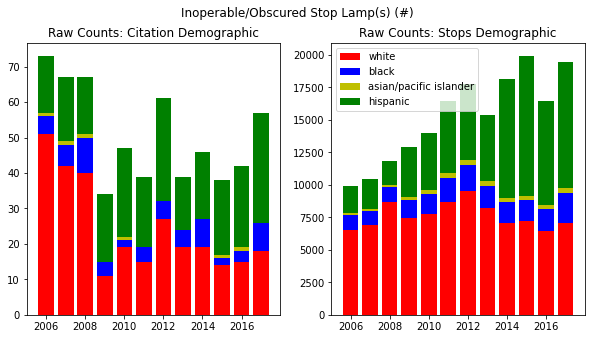

0.9998


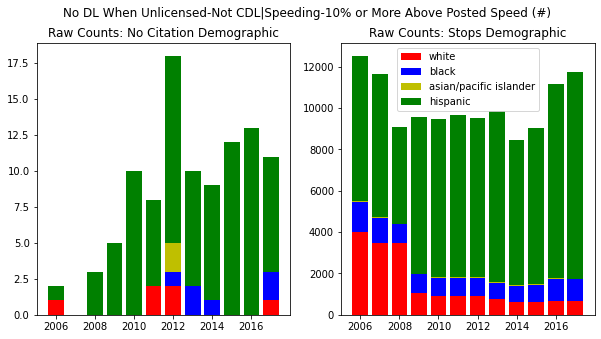

0.0004


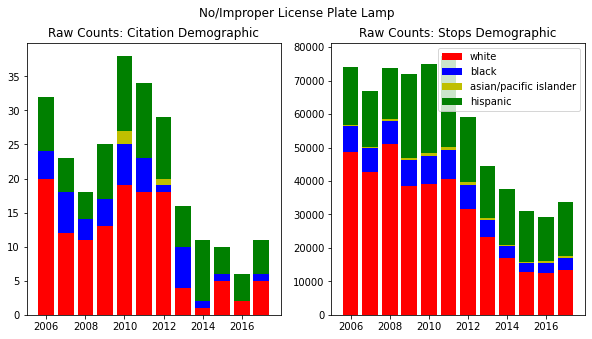

0.0126


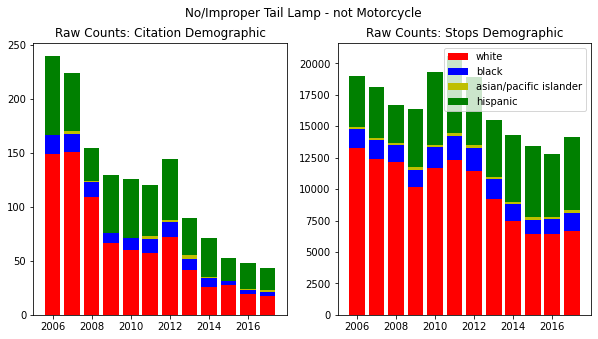

0.003


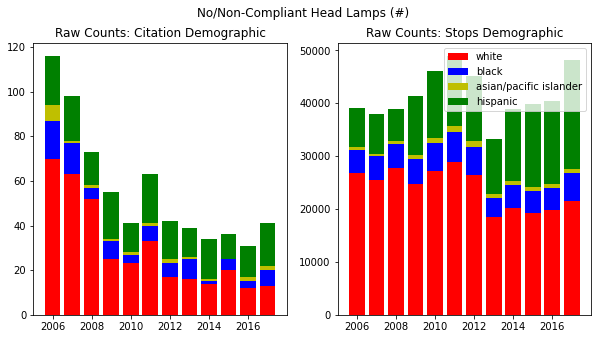

0.007


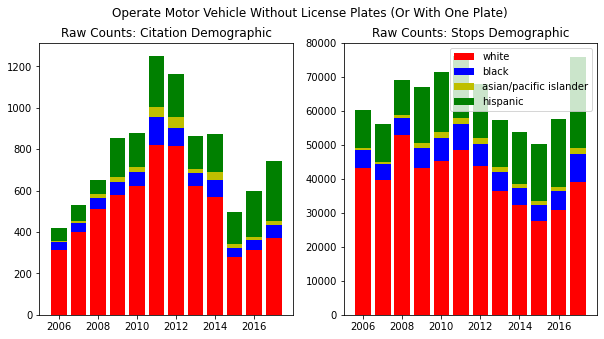

0.0025


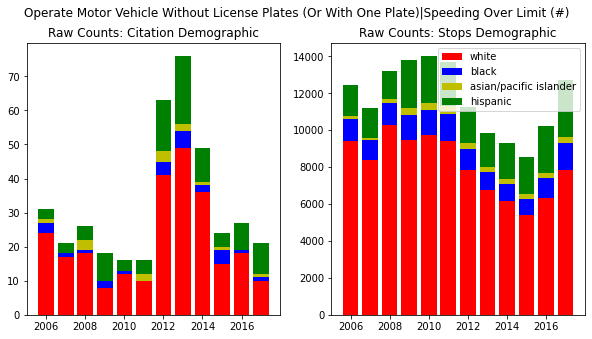

0.0026


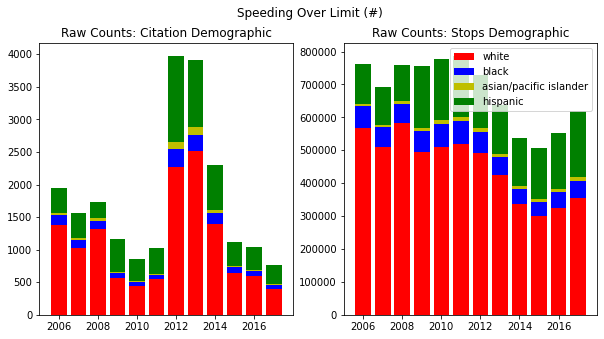

0.9949


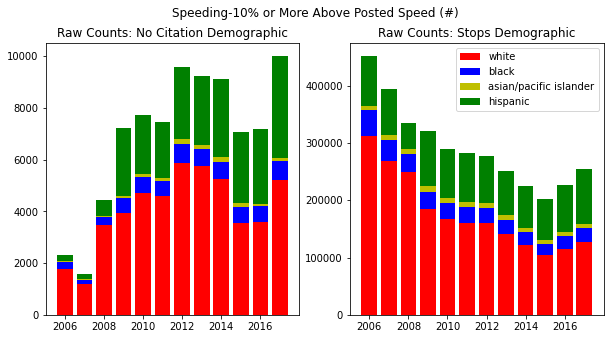

In [ ]:
output_path = 'raw_cnt_allcounties_yearly.csv'
cnt_csv_visualization(output_path, visual = True, county=None)

In [ ]:
res_df = pd.read_csv('/content/raw_cnt_allcounties_yearly.csv')
res_df.sort_values(by='citation_rate')

,violation,total_stops,citations,citation_rate,white,hispanic,black,asian/pacific islander,unknown,other,stop_white,stop_hispanic,stop_black,stop_asian/pacific islander,stop_unknwon,stop_other,year
34,No/Improper License Plate Lamp,76876,18,0.0002,11,4,3,0,0,0,51111,15315,6835,584,2946,85,2008
164,No/Improper License Plate Lamp,29260,6,0.0002,2,4,0,0,0,0,12649,13255,2909,417,0,30,2016
132,No/Improper License Plate Lamp,39008,11,0.0003,1,9,1,0,0,0,16944,16771,3543,409,1259,82,2014
18,No/Improper License Plate Lamp,67553,23,0.0003,12,5,6,0,0,0,42772,16823,7006,472,446,34,2007
50,No/Improper License Plate Lamp,74223,25,0.0003,13,8,4,0,0,0,38405,24894,7891,734,2208,91,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,No DL When Unlicensed-Not CDL|Speeding-10% or ...,9842,9834,0.9992,2,6,0,0,0,0,926,7861,853,35,158,8,2011
63,No DL When Unlicensed-Not CDL|Speeding-10% or ...,9722,9717,0.9995,0,5,0,0,0,0,1059,7573,892,20,172,6,2009
47,No DL When Unlicensed-Not CDL|Speeding-10% or ...,9450,9447,0.9997,0,3,0,0,0,0,3459,4674,920,29,359,9,2008
13,No DL When Unlicensed-Not CDL|Speeding-10% or ...,12619,12617,0.9998,1,1,0,0,0,0,4009,7028,1427,56,89,10,2006


In [ ]:
res_df.loc[res_df['citation_rate']==1,:]

,violation,total_stops,citations,citation_rate,white,hispanic,black,asian/pacific islander,unknown,other,stop_white,stop_hispanic,stop_black,stop_asian/pacific islander,stop_unknwon,stop_other,year
29,No DL When Unlicensed-Not CDL|Speeding-10% or ...,11756,11756,1.0,0,0,0,0,0,0,3491,6919,1210,38,95,3,2007


In [ ]:
low_vios = []
high_vios = []
top_vios = res_df['violation'].unique()
for vio in top_vios:
  if res_df.loc[res_df['violation']==vio,'citation_rate'].iloc[0]<0.05:
    low_vios.append(vio)
  else:
    high_vios.append(vio)
print(low_vios)
print(high_vios)

['Speeding Over Limit (#)', 'No/Improper License Plate Lamp', 'Operate Motor Vehicle Without License Plates (Or With One Plate)', 'No/Non-Compliant Head Lamps (#)', 'Fail to Maintain Financial Responsibility (#)|Speeding Over Limit (#)', 'Improperly Placed Or Obstructed License Plate (#)', 'No/Improper Tail Lamp - not Motorcycle', 'Fail To Report Change Of Address/Name|Speeding Over Limit (#)', 'Drive On Improved Shoulder When Prohibited', 'Fail To Display Driver License|Speeding Over Limit (#)', 'Fail To Signal Lane Change', 'Operate Motor Vehicle Without License Plates (Or With One Plate)|Speeding Over Limit (#)', 'Inoperable/Obscured Stop Lamp(s) (#)']
['Speeding-10% or More Above Posted Speed (#)', 'Fail to Maintain Financial Responsibility (#)|Speeding-10% or More Above Posted Speed (#)', 'No DL When Unlicensed-Not CDL|Speeding-10% or More Above Posted Speed (#)']


### Logistic Regression for low citation rate/high citation rate categories combined

In [ ]:
keep_col = ['county_name', 
            'subject_race',
            'subject_sex',
            'violation', 
            'citation_issued'
            ]
rm_na_col = ['county_name','violation','subject_race','subject_sex']

def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)

def preprocess(year, keep_col, rm_na_col, violation_types):
  # read dataframe
  filename = '/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print('# of All traffic stops: ', len(df))

  print('Filtering: violations combined')
  df = df.loc[df['violation'].isin(violation_types),:]

  # invalid value
  if year == 2013:
    df.drop(df.index[df['lat'] == 74.052879], inplace=True)

  ## drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)

  ## County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/gdrive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county'] = [name[:-7] for name in df['county_name']]
  df['county'] = df['county'].replace('Dewitt','DeWitt')
  df = df.join(county_df.set_index('County Name'), on='county')
  df.drop('county', axis = 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  # Convert 'citation issued' to integer
  df = df.astype({'citation_issued': 'int64'})

  # if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()

  print(df['subject_sex'].value_counts(dropna = False))
  print(df['subject_race'].value_counts(dropna = False))
  print(df['county_type'].value_counts(dropna = False))

  print('# of violation type traffic stops: ', len(df))
  return df 

In [ ]:
def run_year_analysis(keep_col, rm_na_col, df_years, violation):
  """
  Input:
  #data_path: the folder path where all the yearly-based parquet files are saved

  #output_path: output path for csv files -> not used yet, because I want to print out the result and directly 
  #save it afterwards. After we make sure there is no problem about how I did the analysis, we integrate this part
  #into the function

  keep_col, rm_na_col,violation_type: parameters for preprocessing
  df_years: an empty data frame where we can save the logistic regression results
  model: 'baseline' or 'interaction'
  Output:
  A result dataframe
  """
  years = list(range(2006,2018))
  for year in years:
    # read in the data
    print('***********************************')
    print(year)

    # read in and preprocess data
    df = preprocess(year, keep_col, rm_na_col, violation_types = violation)
    if len(df) == 0:
      print('WARNING: ',violation,' has 0 records in ', year, '!!')
      return 0
    y = df['citation_issued']
    X = df.drop('citation_issued', axis = 1)
    X.drop(['county_name','violation'], axis = 1, inplace = True)
    
    # Those columns also contain no useful information. So, we drop those columns
    #for col in X.columns:
      #if len(X.loc[X[col] == 0,:]) == len(X):
        #X.drop(col, axis = 1, inplace = True)
        #print(year, ': ','Delete ', col)
    
    # get dummies for race, sex, daylight,holiday
    X = pd.get_dummies(X)
    #sex_dict = {'male':0, 'female':1}
    #X['subject_sex'] = X['subject_sex'].map(sex_dict)
    # for baseline model
    # Base level: male, White, Metropolitan (county type), holiday = 0
    X.drop(['subject_race_white', 'county_type_Metropolitan','subject_sex_male'], axis = 1, inplace = True)

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})

    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)), 
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file


### Logistic Regression for violation types with high ciation rates-combined

#### Low violation rates combined

***********************************
2006
# of All traffic stops:  2693894
Filtering: violations combined
male      735563
female    352862
Name: subject_sex, dtype: int64
white                     790366
hispanic                  189761
black                      98904
asian/pacific islander      9394
Name: subject_race, dtype: int64
Metropolitan    556059
Non core        316134
Micropolitan    216232
Name: county_type, dtype: int64
# of violation type traffic stops:  1088425


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.024529
         Iterations 10
***********************************
2007
# of All traffic stops:  2427347
Filtering: violations combined
male      676008
female    317843
Name: subject_sex, dtype: int64
white                     711195
hispanic                  183996
black                      89220
asian/pacific islander      9440
Name: subject_race, dtype: int64
Metropolitan    508981
Non core        289845
Micropolitan    195025
Name: county_type, dtype: int64
# of violation type traffic stops:  993851
Optimization terminated successfully.
         Current function value: 0.024120
         Iterations 10
***********************************
2008
# of All traffic stops:  2526783
Filtering: violations combined
male      750162
female    340828
Name: subject_sex, dtype: int64
white                     821615
hispanic                  169987
black                      87328
asian/pacific islander     12060
Name: subje

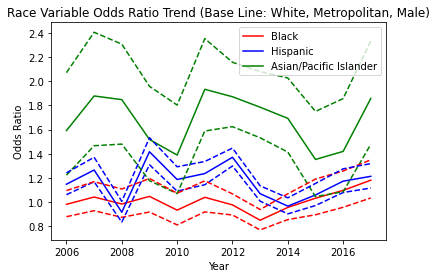

In [ ]:
# for violation types combined
var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                      'county_type_Non core', 'county_type_Micropolitan','subject_sex_female']
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years,violation=low_vios)

# save csv
file_name = 'ORCI_low_vios_conbined.csv'
save_path = file_name
res_df.to_csv(save_path)

years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')

plt.title('Race Variable Odds Ratio Trend (Base Line: White, Metropolitan, Male)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig(('ORCI_low_vios_conbined.svg'), format = 'svg')
plt.savefig(('ORCI_low_vios_combined.jpg'), dpi = 200)
plt.show()

#### High Violation rates combined

***********************************
2006
# of All traffic stops:  2693894
Filtering: violations combined
male      345412
female    167083
Name: subject_sex, dtype: int64
white                     348344
hispanic                  104983
black                      50183
asian/pacific islander      8985
Name: subject_race, dtype: int64
Metropolitan    285684
Non core        146693
Micropolitan     80118
Name: county_type, dtype: int64
# of violation type traffic stops:  512495


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.029194
         Iterations 10
***********************************
2007
# of All traffic stops:  2427347
Filtering: violations combined
male      303218
female    145758
Name: subject_sex, dtype: int64
white                     299989
hispanic                   98685
black                      42272
asian/pacific islander      8030
Name: subject_race, dtype: int64
Metropolitan    248530
Non core        127621
Micropolitan     72825
Name: county_type, dtype: int64
# of violation type traffic stops:  448976
Optimization terminated successfully.
         Current function value: 0.023743
         Iterations 10
***********************************
2008
# of All traffic stops:  2526783
Filtering: violations combined
male      251974
female    124263
Name: subject_sex, dtype: int64
white                     276831
hispanic                   55441
black                      35772
asian/pacific islander      8193
Name: subje

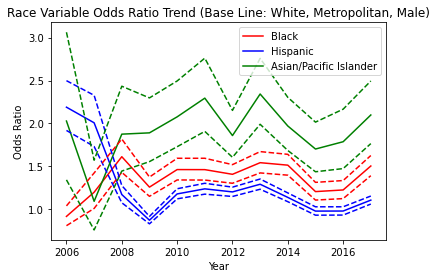

In [ ]:
# for violation types combined
var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                      'county_type_Non core', 'county_type_Micropolitan','subject_sex_female']
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years,violation=high_vios)

# save csv
file_name = 'ORCI_high_vios_conbined.csv'
save_path = file_name
res_df.to_csv(save_path)

years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')

plt.title('Race Variable Odds Ratio Trend (Base Line: White, Metropolitan, Male)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig(('ORCI_high_vios_conbined.svg'), format = 'svg')
plt.savefig(('ORCI_high_vios_combined.jpg'), dpi = 200)
plt.show()

### Ignore below

In [ ]:
res_df.groupby('violation').size()

violation
Display Expired License Plates/Registration (#)|Speeding Over Limit (#)                       7
Drive On Improved Shoulder When Prohibited                                                   12
Drive in Left Lane When Not Passing or Where Prohibited                                      10
Drive in Left Lane When Not Passing or Where Prohibited|Speeding Over Limit (#)               1
Fail To Control Speed (#)                                                                     4
Fail To Display Driver License|Speeding Over Limit (#)                                       12
Fail To Display Driver License|Speeding-10% or More Above Posted Speed (#)                    1
Fail To Report Change Of Address/Name|Speeding Over Limit (#)                                12
Fail To Report Change Of Address/Name|Speeding-10% or More Above Posted Speed (#)             3
Fail To Signal Lane Change                                                                   12
Fail to Maintain Financial Res

In [ ]:
s = res_df.groupby('violation').size()
vios = list(s.loc[s==12].index)
filtered_res_df = res_df.loc[res_df['violation'].isin(vios),:]
filtered_res_df

,violation,total_stops,citations,citation_rate,white,hispanic,black,asian/pacific islander,unknown,other,year
0,Speeding Over Limit (#),767317,1963,0.0026,1382,388,154,24,12,3,2006
1,Speeding-10% or More Above Posted Speed (#),457629,455316,0.9949,1761,243,277,23,6,3,2006
2,No/Improper License Plate Lamp,74549,33,0.0004,20,8,4,0,1,0,2006
4,Operate Motor Vehicle Without License Plates (...,60842,427,0.0070,313,59,41,5,8,1,2006
5,Fail to Maintain Financial Responsibility (#)|...,48648,48576,0.9985,55,9,8,0,0,0,2006
...,...,...,...,...,...,...,...,...,...,...,...
275,No DL When Unlicensed-Not CDL|Speeding-10% or ...,11756,11745,0.9991,1,8,2,0,0,0,2017
277,Fail To Report Change Of Address/Name|Speeding...,11431,16,0.0014,9,3,4,0,0,0,2017
278,Fail to Maintain Financial Responsibility (#)|...,9053,8930,0.9864,55,58,9,1,0,0,2017
279,Fail To Display Driver License|Speeding Over L...,8923,11,0.0012,4,5,2,0,0,0,2017


In [ ]:
vis_df = filtered_res_df.loc[filtered_res_df['violation'] == 'Speeding Over Limit (#)',:]
vis_df['citation_rate'].iloc[0]

0.0026

0.0331


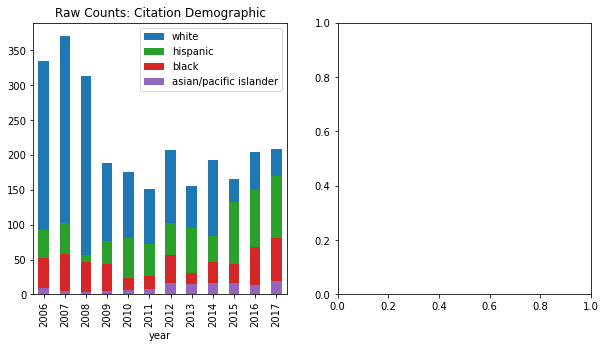

0.0028


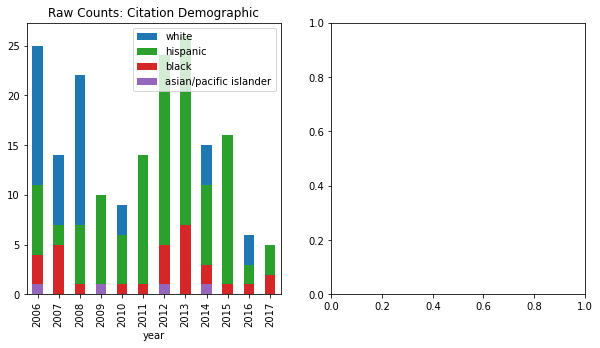

0.0033


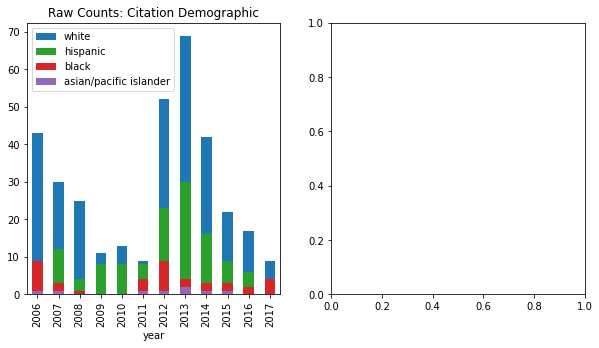

0.0235


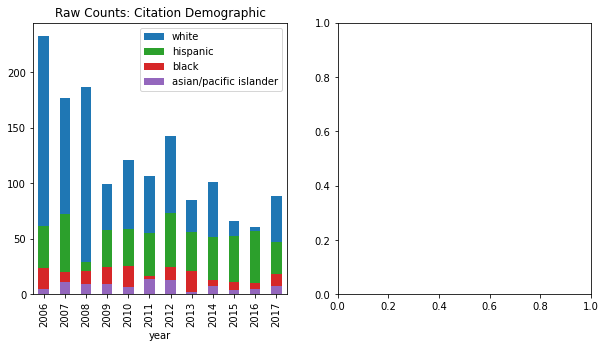

0.0094


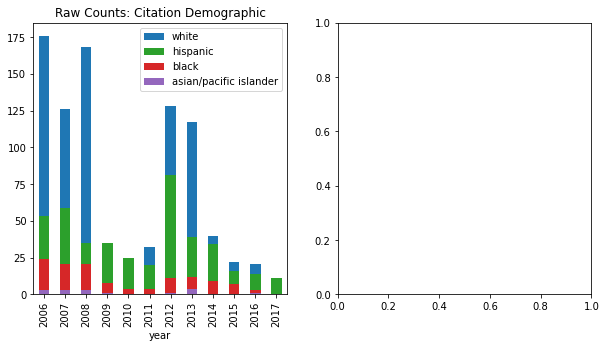

0.9985


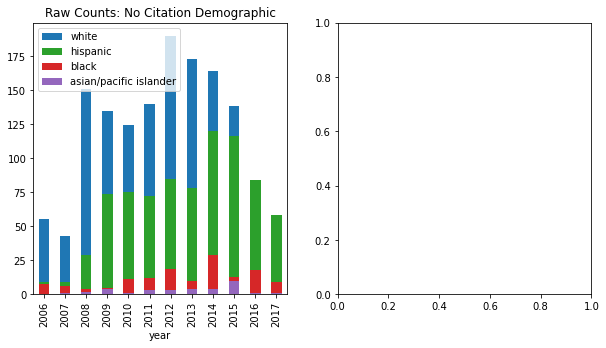

0.0021


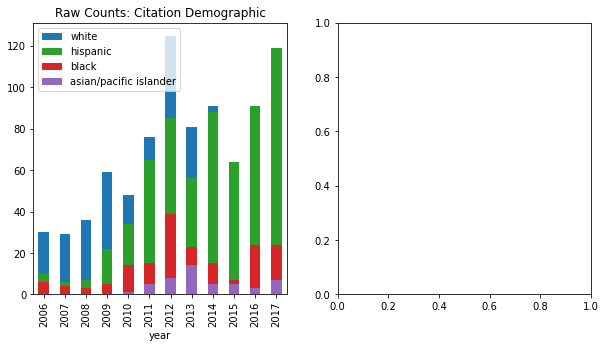

0.0075


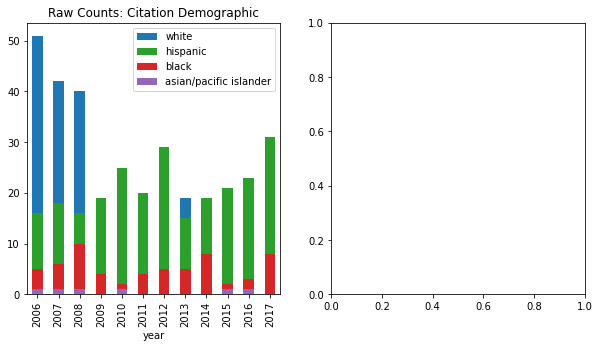

0.9998


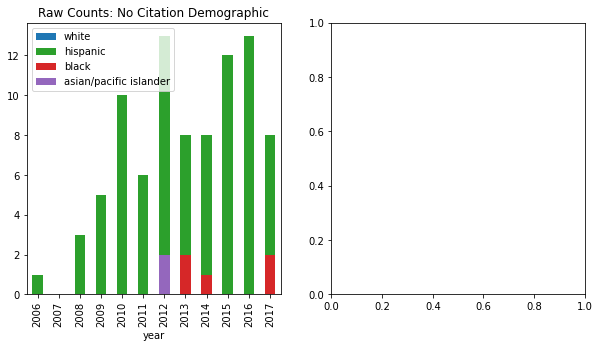

0.0004


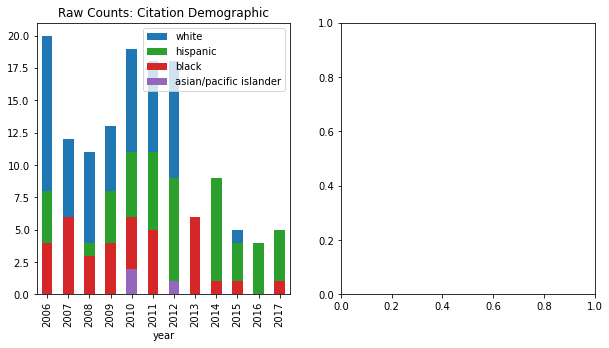

0.0126


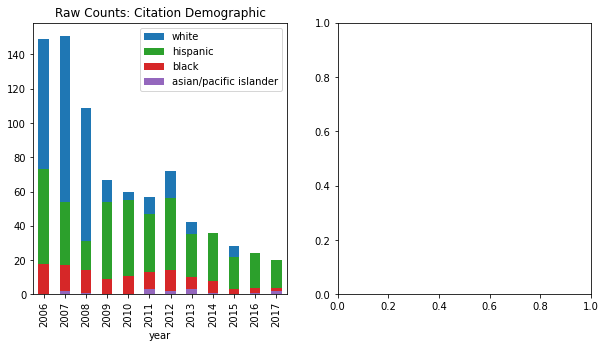

0.003


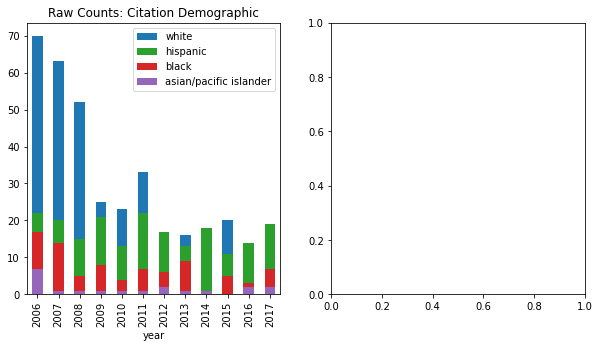

0.007


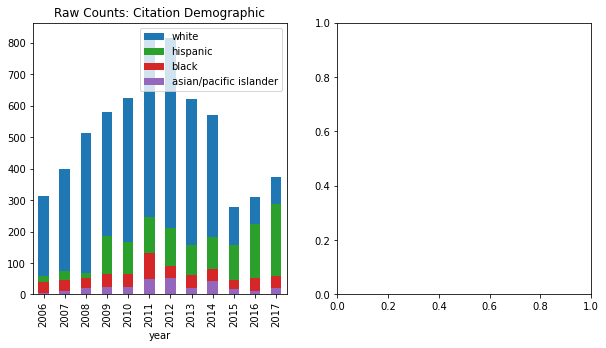

0.0025


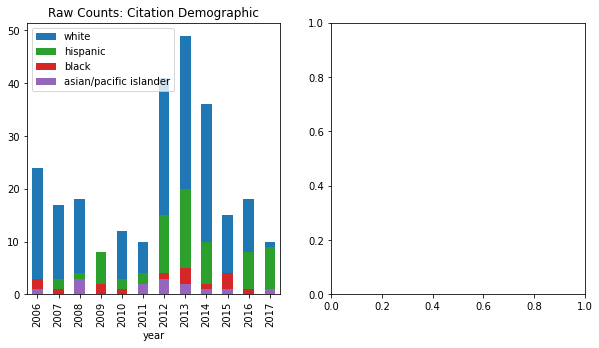

0.0026


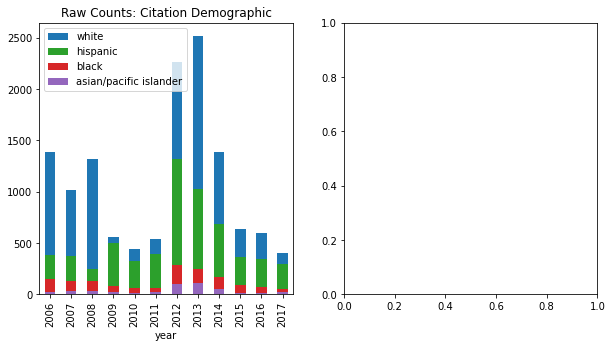

0.9949


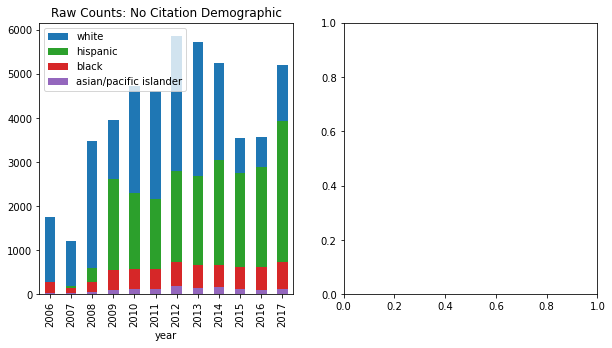

In [ ]:
for vio in vios:
  vis_df = filtered_res_df.loc[filtered_res_df['violation'] == vio,:]
  print(vis_df['citation_rate'].iloc[0])
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

  vis_df.plot(x="year", y="hispanic", kind="bar", ax=ax1)
  vis_df.plot(x="year", y="black", kind="bar", ax=ax1, color="C2")
  vis_df.plot(x="year", y="asian/pacific islander", kind="bar", ax=ax1, color="C3")
  vis_df.plot(x="year", y="white", ax = ax1, kind="bar", color="C4")

  if vis_df['citation_rate'].iloc[0] < 0.05:
    ax1.set_title('Raw Counts: Citation Demographic')
  else:
    ax1.set_title('Raw Counts: No Citation Demographic')

  vis_df.plot(x="year", y="hispanic", kind="bar", ax=ax2)
  vis_df.plot(x="year", y="black", kind="bar", ax=ax2, color="C2")
  vis_df.plot(x="year", y="asian/pacific islander", kind="bar", ax=ax2, color="C3")
  vis_df.plot(x="year", y="white", ax = ax2, kind="bar",color="C4")

  ax2.set_title('Raw Counts: Stops Demographic')

  plt.show()

### ignore below

In [ ]:
res_df.sort_values(['violation','year'])

,violation,total_stops,citations,citation_rate,white,hispanic,black,asian/pacific islander,unknown,other,year,NaN,NaN
68,Display Expired License Plates/Registration (#...,10116,22,0.0022,15,3,3,0,1,0,2008,NaN,NaN
93,Display Expired License Plates/Registration (#...,10018,14,0.0014,9,4,0,0,1,0,2009,NaN,NaN
115,Display Expired License Plates/Registration (#...,10520,11,0.0010,6,4,1,0,0,0,2010,NaN,NaN
138,Display Expired License Plates/Registration (#...,10352,11,0.0011,6,5,0,0,0,0,2011,NaN,NaN
233,Display Expired License Plates/Registration (#...,7825,28,0.0036,17,8,2,0,1,0,2015,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Speeding-10% or More Above Posted Speed (#),233453,224078,0.9598,5255,3048,669,162,224,17,2014,NaN,NaN
211,Speeding-10% or More Above Posted Speed (#),212943,205666,0.9658,3544,2752,626,133,203,19,2015,NaN,NaN
235,Speeding-10% or More Above Posted Speed (#),226539,219343,0.9682,3572,2896,615,108,0,5,2016,NaN,NaN
260,Speeding-10% or More Above Posted Speed (#),254732,244721,0.9607,5205,3928,739,134,0,5,2017,NaN,NaN


In [ ]:
inspect_violation(2015)

Speeding Over Limit (#)                                                                      529145
Speeding-10% or More Above Posted Speed (#)                                                  212943
Operate Motor Vehicle Without License Plates (Or With One Plate)                              51777
No/Non-Compliant Head Lamps (#)                                                               41910
No/Improper License Plate Lamp                                                                32274
Improperly Placed Or Obstructed License Plate (#)                                             25272
Inoperable/Obscured Stop Lamp(s) (#)                                                          20337
Display Expired License Plates/Registration (#)                                               19992
Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)                                         18251
Drive in Left Lane When Not Passing or Where Prohibited                                       16645


,violation,citation_rate
16,Speeding Over Limit (#)|Driving While License ...,1.0000
13,Speeding Over Limit (#)|No DL When Unlicensed-...,1.0000
12,Failure to Pay Toll (For NTTA Use Only),0.9998
21,No DL When Unlicensed-Not CDL|Speeding-10% or ...,0.9987
24,Fail To Control Speed (#),0.9823
1,Speeding-10% or More Above Posted Speed (#),0.9658
27,Fail to Maintain Financial Responsibility (#)|...,0.9654
8,"Ride, Not Secured By Safety Belt-Driver (12-1-...",0.6075
17,"Ride, Not Secured By Safety Belt-Passenger (Wh...",0.6034
20,Disregard Stop Sign (#),0.2560


In [ ]:
import numpy as np
np.minimum(2,3)

2